# Notebook Structure Overview:


## Part 1: Data Preprocessing
 --------------------------
- Load data from the drive.
- Preprocess the data to be suitable for LSTM model input, including scaling, normalization

## Part 2: Model Training
 ----------------------
 - Defining an LSTM model architecture suitable for time series forecasting of network traffic.
-  Train the LSTM model using historical data of transfer traffic, network throughput, and transmission durations.

## Part 3: Model Testing
 ---------------------
 - Test the trained LSTM model by performing predictions on the test set.
 - Evaluate the model's performance using appropriate metrics Mean Absolute Error

## Part 4: PID Integration for Prediction Improvement
 --------------------------------------------------
- Integrate a PID controller to refine the predictions made by the LSTM model.
- Adjust the PID parameters (Ki, Kp, Kd) to minimize prediction error, potentially enhancing accuracy.


# **Importing necessary libraries and modules**

In [1]:
import os
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Nadam
from keras import regularizers, backend as K, utils
from keras.regularizers import Regularizer
from tensorflow.keras.regularizers import L1L2
from keras.utils import register_keras_serializable
from google.colab import drive
from datetime import datetime

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)


# Part 1: Connecting to the drive to acces the data

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading the data
The data was preprocessed and stored on the drive for easier accesibility


*   preprocessed_train_data is the data collected for the iperf ran for the duration of 10,20,30,40 Seconds
*   preprocessed_val_data is the data collected for the iperf ran for the duration of 50 Seconds.
*   preprocessed_test_data is the data collected for the iperf ran for the duration of 60 Seconds.
*   preprocessed_train_val_data is a combination of both train and validation sets

In [3]:
DATAPATH = '/content/gdrive/My Drive/Data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'

TRAINVALDATAFILE = DATAPATH+'preprocessed_train_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)

train_all_dataset = read_csv(TRAINVALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

print(train_dataset.shape)
print(val_dataset.shape)
print(train_all_dataset.shape)
print(test_dataset.shape)

(1584, 6)
(392, 6)
(1976, 6)
(391, 6)


# Bringing in new data (more data was collected to increase on the dataset size)

In [4]:
New_data = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_10s.txt')
New_data1 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_20s.txt')
New_data2 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_30s.txt')
New_data3 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_40s.txt')
New_data4 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_50s.txt')
New_data5 = pd.read_fwf('/content/gdrive/My Drive/Data/More_data_single_flows/More_data_60s.txt')

In [ ]:
# List to store dataframes
data_frames = []

# File names for single-flow data
file_names = ['More_data_10s.txt', 'More_data_20s.txt', 'More_data_30s.txt',
              'More_data_40s.txt', 'More_data_50s.txt', 'More_data_60s.txt']

# Reading single-flow data files
for file_name in file_names:
    file_path = f'/content/gdrive/My Drive/Data/More_data_single_flows/{file_name}'
    data_frames.append(pd.read_fwf(file_path))

# Reading multi-flow data file
multi_flow = pd.read_fwf('/content/gdrive/My Drive/Data/Multi_flows_data/multi_flows4.txt')


# Below are a few data-preprocessing steps to combine old_data with new_data

In [6]:
datasets = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]

In [7]:
# Defining a function to apply the operation for removing strings from the data
def extract_and_convert_to_float(df):
    for column in df.columns:
      if pd.api.types.is_string_dtype(df[column]):
        df[column] = df[column].str.extract(r'(\d+[.\d]*)').astype(float)
    return df

for df in datasets:
    df = extract_and_convert_to_float(df)

In [9]:
# Operation to only keep the necessary columns / features
data_frames = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]
for df in data_frames:
   df.drop(columns=df.columns.difference(['Transfer', 'Bandwidth']), inplace=True)

In [10]:
# Adding a duration column to the new_data
data_frames = [New_data, New_data1, New_data2, New_data3, New_data4, New_data5]
for df, duration in zip(data_frames, range(10, 70, 10)):
    df['Duration'] = duration
    df.rename(columns={'Bandwidth': 'Bandwidth (Mbits/sec)', 'Transfer': 'Transferred Traffic (KBytes)'}, inplace=True)

In [11]:
# Changing the transffered data into MBytes (for data transffered for 10s)
New_data['Transferred Traffic (KBytes)'] = New_data['Transferred Traffic (KBytes)'] / 1024

In [12]:
# # Combining the first 4 new datasets (collected for 10s,20s,30s, and 40s)which will be added to the training_set
combined_New_data = pd.concat([New_data, New_data1, New_data2, New_data3], ignore_index=True)
combined_New_data.reset_index(drop=True, inplace=True)

In [13]:
# Making some spelling correction in the old data
old_data_frames = [train_dataset, val_dataset, test_dataset, train_all_dataset]
for df in old_data_frames:
    df.rename(columns={'Bandwidth': 'Bandwidth (Mbits/sec)', 'Tranfered Trafic (KBytes)': 'Transferred Traffic (KBytes)'}, inplace=True)

In [14]:
# Defining the columns / features to keep in our old dataset
columns_to_keep = ['Bandwidth (Mbits/sec)', 'Duration', 'Transferred Traffic (KBytes)']
train_dataset = train_dataset[columns_to_keep]
val_dataset = val_dataset[columns_to_keep]
test_dataset = test_dataset[columns_to_keep]

In [15]:
# Combining the old dataset with the new dataset
New_train_data = pd.concat([train_dataset, combined_New_data], ignore_index=True)
New_val_data = pd.concat([val_dataset, New_data4], ignore_index=True)
New_test_data = pd.concat([test_dataset, New_data5], ignore_index=True)

In [16]:
# Selecting out data to make re-arrangements in it
df_10 = New_train_data[New_train_data['Duration'] == 10]
df_20 = New_train_data[New_train_data['Duration'] == 20]
df_30 = New_train_data[New_train_data['Duration'] == 30]
df_40 = New_train_data[New_train_data['Duration'] == 40]

In [17]:
# combining the new_train data in the right order
train_data_final = pd.concat([df_10, df_20, df_30, df_40], ignore_index=True)

In [18]:
# combining the new_train data with the validation_data to make a big richer train_data_final_all
train_data_final_all = pd.concat([train_data_final, New_val_data], ignore_index=True)

In [19]:
# Extracting data from dataframes, selecting the features
# The labels simply contain the Transffered Trafic

#  Selecting which features to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)

    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

features = ['Bandwidth (Mbits/sec)', 'Duration', 'Transferred Traffic (KBytes)']

# Important: Tensorflow 2.x gives an error omitting
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(feature_matrix(train_data_final,features),dtype=np.float32)
train_labels = np.asarray(train_data_final['Transferred Traffic (KBytes)'],dtype=np.float32)

val_values = np.asarray(feature_matrix(New_val_data,features),dtype=np.float32)
val_labels = np.asarray(New_val_data['Transferred Traffic (KBytes)'],dtype=np.float32)

# data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_data_final_all,features),dtype=np.float32)
train_all_labels = np.asarray(train_data_final_all['Transferred Traffic (KBytes)'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(New_test_data,features),dtype=np.float32)
test_labels = np.asarray(New_test_data['Transferred Traffic (KBytes)'],dtype=np.float32)



# checking out the data
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)



(4701, 3)
(4701,)
(1172, 3)
(1172,)
(5873, 3)
(5873,)
(1171, 3)
(1171,)


In [20]:
# Scaling the data to the right format for our model (using MinMaxScaler)
from sklearn.preprocessing import StandardScaler
SS1 = MinMaxScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)


SS2 = MinMaxScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

# Setting the desired WINDOW_SIZE

In [22]:
WINDOW_SIZE = 1

In [23]:
# window-based and recurrent networks:
# making predictions seconds ahead. NB: 8 = 4seconds ....
# for now the window size is set to WINDOW_SIZE

def create_dataset_windowed(features, labels, ahead=2, window_size=WINDOW_SIZE, max_window_size=50):
    samples = features.shape[0]-ahead-(max_window_size-1)
    window_size = min(max(window_size,1),max_window_size)

    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]



## Creating the windowed dataset from training and validation data

In [24]:
X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels)
X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels)

# Part 2: Model training (first on the training and validation sets)

In [25]:
# Setting the number of units for the hidden layer in the RNN to 256
HIDDEN_RNN = 256
# regularisers - all set to zero for now
wreg = L1L2(l1=0.001, l2=0.01)

LSTMmodel = Sequential()

# Adding layers to the model
LSTMmodel.add(Dense(32, input_shape=(WINDOW_SIZE,3), activation='relu'))
LSTMmodel.add(LSTM(input_shape = (WINDOW_SIZE,3),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTMmodel.add(Dense(16,activation='relu'))
LSTMmodel.add(Dense(8,activation='relu'))
LSTMmodel.add(Dense(4,activation='relu'))
LSTMmodel.add(Dense(1))
LSTMmodel.summary()

LSTMmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

batch_size=16
epochs=40

# Training the model
LSTMhistory = LSTMmodel.fit(X_train_w, r_train_w,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 32)             128       
                                                                 
 lstm (LSTM)                 (None, 256)               295936    
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 300353 (1.15 MB)
Trainable params: 300353 

In [26]:
# Plotting the history of Mean Absolute Error for training and validation sets
def plot_history(history):
  plt.figure(figsize = (6,4))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

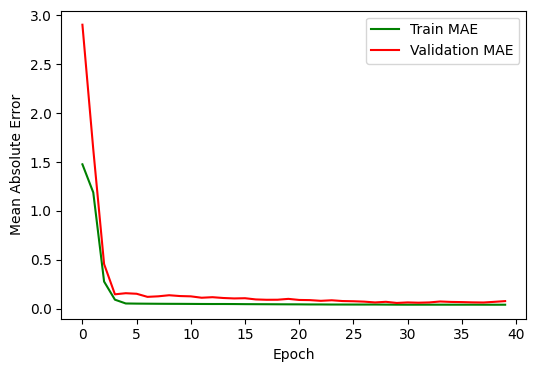

In [27]:
plot_history(LSTMhistory)

In [ ]:
from sklearn.metrics import mean_absolute_error
# Making predictions using the trained model
y_train_LSTM = LSTMmodel.predict(X_train_w)
y_val_LSTM = LSTMmodel.predict(X_val_w)

# Calculating the mean absolute error from the training and validation sets
mae_train_LSTM = mean_absolute_error(r_train_w, y_train_LSTM)
mae_val_LSTM = mean_absolute_error(r_val_w, y_val_LSTM)

# Printing the mean absolute error from the training and validation sets
print("\ train mae = ", mae_train_LSTM,
      "\n validation mae = ", mae_val_LSTM)

# Printing the shapes of the predicted output from the training and validation sets
print(y_train_LSTM.shape)
print(y_val_LSTM.shape)

32/32 [==============================] - 0s 3ms/step
\ train mae =  0.08731402 
 validation mae =  0.05918524
(4532, 1)
(1003, 1)


# Evaluating the model performance on the test_set this time combining the training and validation set to form a richer (train_all dataset) which is a bigger dataset




In [28]:
# creating the widowed dataset
X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels)
X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels)

print(X_train_all_w.shape)
print(r_train_all_w.shape)
print(X_test_w.shape)
print(r_test_w.shape)

(5822, 1, 3)
(5822,)
(1120, 1, 3)
(1120,)


# Part 2: Training the model on the whole training set (train + validation sets) and evaluating it on the test set.

In [29]:
# Setting the number of units for the hidden layer in the RNN to 256
HIDDEN_RNN = 256
# regularisers - all set to zero for now
wreg = L1L2(l1=0.001, l2=0.01)

LSTMmodel_test = Sequential()

# Adding layers to the model
LSTMmodel_test.add(Dense(32, input_shape=(WINDOW_SIZE,3), activation='relu'))
LSTMmodel_test.add(LSTM(input_shape = (WINDOW_SIZE,3),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTMmodel_test.add(Dense(16,activation='relu'))
LSTMmodel_test.add(Dense(8,activation='relu'))
LSTMmodel_test.add(Dense(4,activation='relu'))
LSTMmodel_test.add(Dense(1))
LSTMmodel_test.summary()

LSTMmodel_test.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

batch_size=16
epochs=40

# Training the model
LSTMhistory_test = LSTMmodel_test.fit(X_train_all_w, r_train_all_w,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_w, r_test_w),
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1, 32)             128       
                                                                 
 lstm_1 (LSTM)               (None, 256)               295936    
                                                                 
 dense_6 (Dense)             (None, 16)                4112      
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 4)                 36        
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 300353 (1.15 MB)
Trainable params: 30035

# Plotting the training loss curves

In [50]:
# Plotting the history of Mean Absolute Error for training and validation sets
def plot_history_test(history):
  # Creating a figure with higher DPI for better resolution
  plt.figure(figsize=(5, 3), dpi=200)

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.title('Model Training Loss Curves')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Training MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Test MAE')
  plt.legend()
  plt.show()

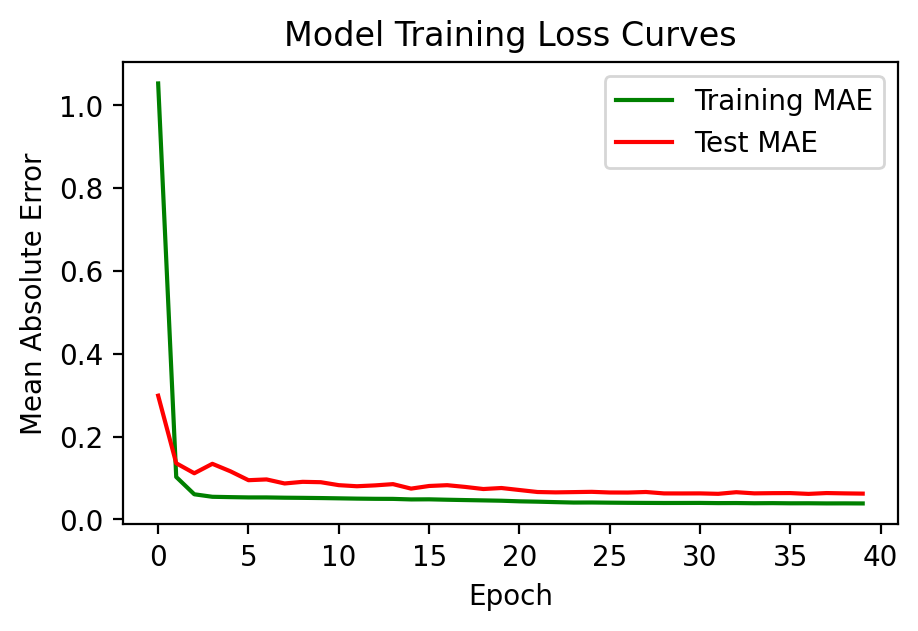

In [51]:
plot_history_test(LSTMhistory_test)

# Part 3: Evaluation using MAE

In [32]:
from sklearn.metrics import mean_absolute_error
# Making predictions using the trained model
y_train_all_LSTM = LSTMmodel_test.predict(X_train_all_w)
y_test_LSTM = LSTMmodel_test.predict(X_test_w)

# Calculating the mean absolute error from the training_all_dataset and test sets
mae_train_all_LSTM = mean_absolute_error(r_train_all_w, y_train_all_LSTM)
mae_test_LSTM = mean_absolute_error(r_test_w, y_test_LSTM)

# Printing the mean absolute error from the training_all_dataeet and test sets
print("\ train_all_mae = ", mae_train_all_LSTM,
      "\n test_mae = ", mae_test_LSTM)

# Checking the shapes of the predicted output from the training_all_dataset and test sets
print(y_train_all_LSTM.shape)
print(y_test_LSTM.shape)

35/35 [==============================] - 0s 4ms/step
\ train_all_mae =  0.038832407 
 test_mae =  0.062136747
(5822, 1)
(1120, 1)


## Part 4: **PID Integration to improve our predictions**

In [43]:
# Initializing the PID controller
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        """
        Parameters:
        - Kp (float): Proportional gain coefficient.
        - Ki (float): Integral gain coefficient.
        - Kd (float): Derivative gain coefficient.
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0 # Previous error initialized to zero
        self.integral = 0 # Integral term initialized to zero

    def compute_control_signal(self, error):
        """
        Computing the control signal based on the current error.

        Parameters:
        - error (float): The current error signal.

        Returns:
        - control_signal (float): The computed control signal.
        """
        self.integral += error
        derivative = error - self.prev_error
        self.prev_error = error
        control_signal = self.Kp * error + self.Ki * self.integral + self.Kd * derivative # Computing the control signal using PID formula
        return control_signal

# Defining PID parameters
Kp = 0.3
Ki = 0.00001
Kd = 0.3

# Initializing PID controller
pid_controller = PIDController(Kp, Ki, Kd)

# Setting reference signals
reference_train = r_train_all_w
reference_test = r_test_w

# Initializing PID control signals
control_signal_train = 0
control_signal_test = 0

y_train_all_LSTM_new = []
y_test_LSTM_new = []

# PID control loop
for i in range(len(X_train_all_w)):
    error_train = reference_train[i] - y_train_all_LSTM[i]
    control_signal_train = pid_controller.compute_control_signal(error_train)
    # Applying control signal to model output
    y_train_all_LSTM_new.append(y_train_all_LSTM[i] + control_signal_train)

for i in range(len(X_test_w)):
    error_test = reference_test[i] - y_test_LSTM[i]
    control_signal_test = pid_controller.compute_control_signal(error_test)
    # Applying control signal to model output
    y_test_LSTM_new.append(y_test_LSTM[i] + control_signal_test)

# PID Mean Absolute Error
mae_train_all_LSTM_new = mean_absolute_error(reference_train, y_train_all_LSTM_new)
mae_test_LSTM_new = mean_absolute_error(reference_test, y_test_LSTM_new)

# printing MAE results for comparison
print(f"Old MAE for train: {mae_train_all_LSTM}")
print(f"Old MAE for test: {mae_test_LSTM}")
print(f"New MAE for train: {mae_train_all_LSTM_new}")
print(f"New MAE for test: {mae_test_LSTM_new}")


Old MAE for train: 0.0388324074447155
Old MAE for test: 0.06213674694299698
New MAE for train: 0.025830985978245735
New MAE for test: 0.033322568982839584


# Plotting to visualize the prediction curves

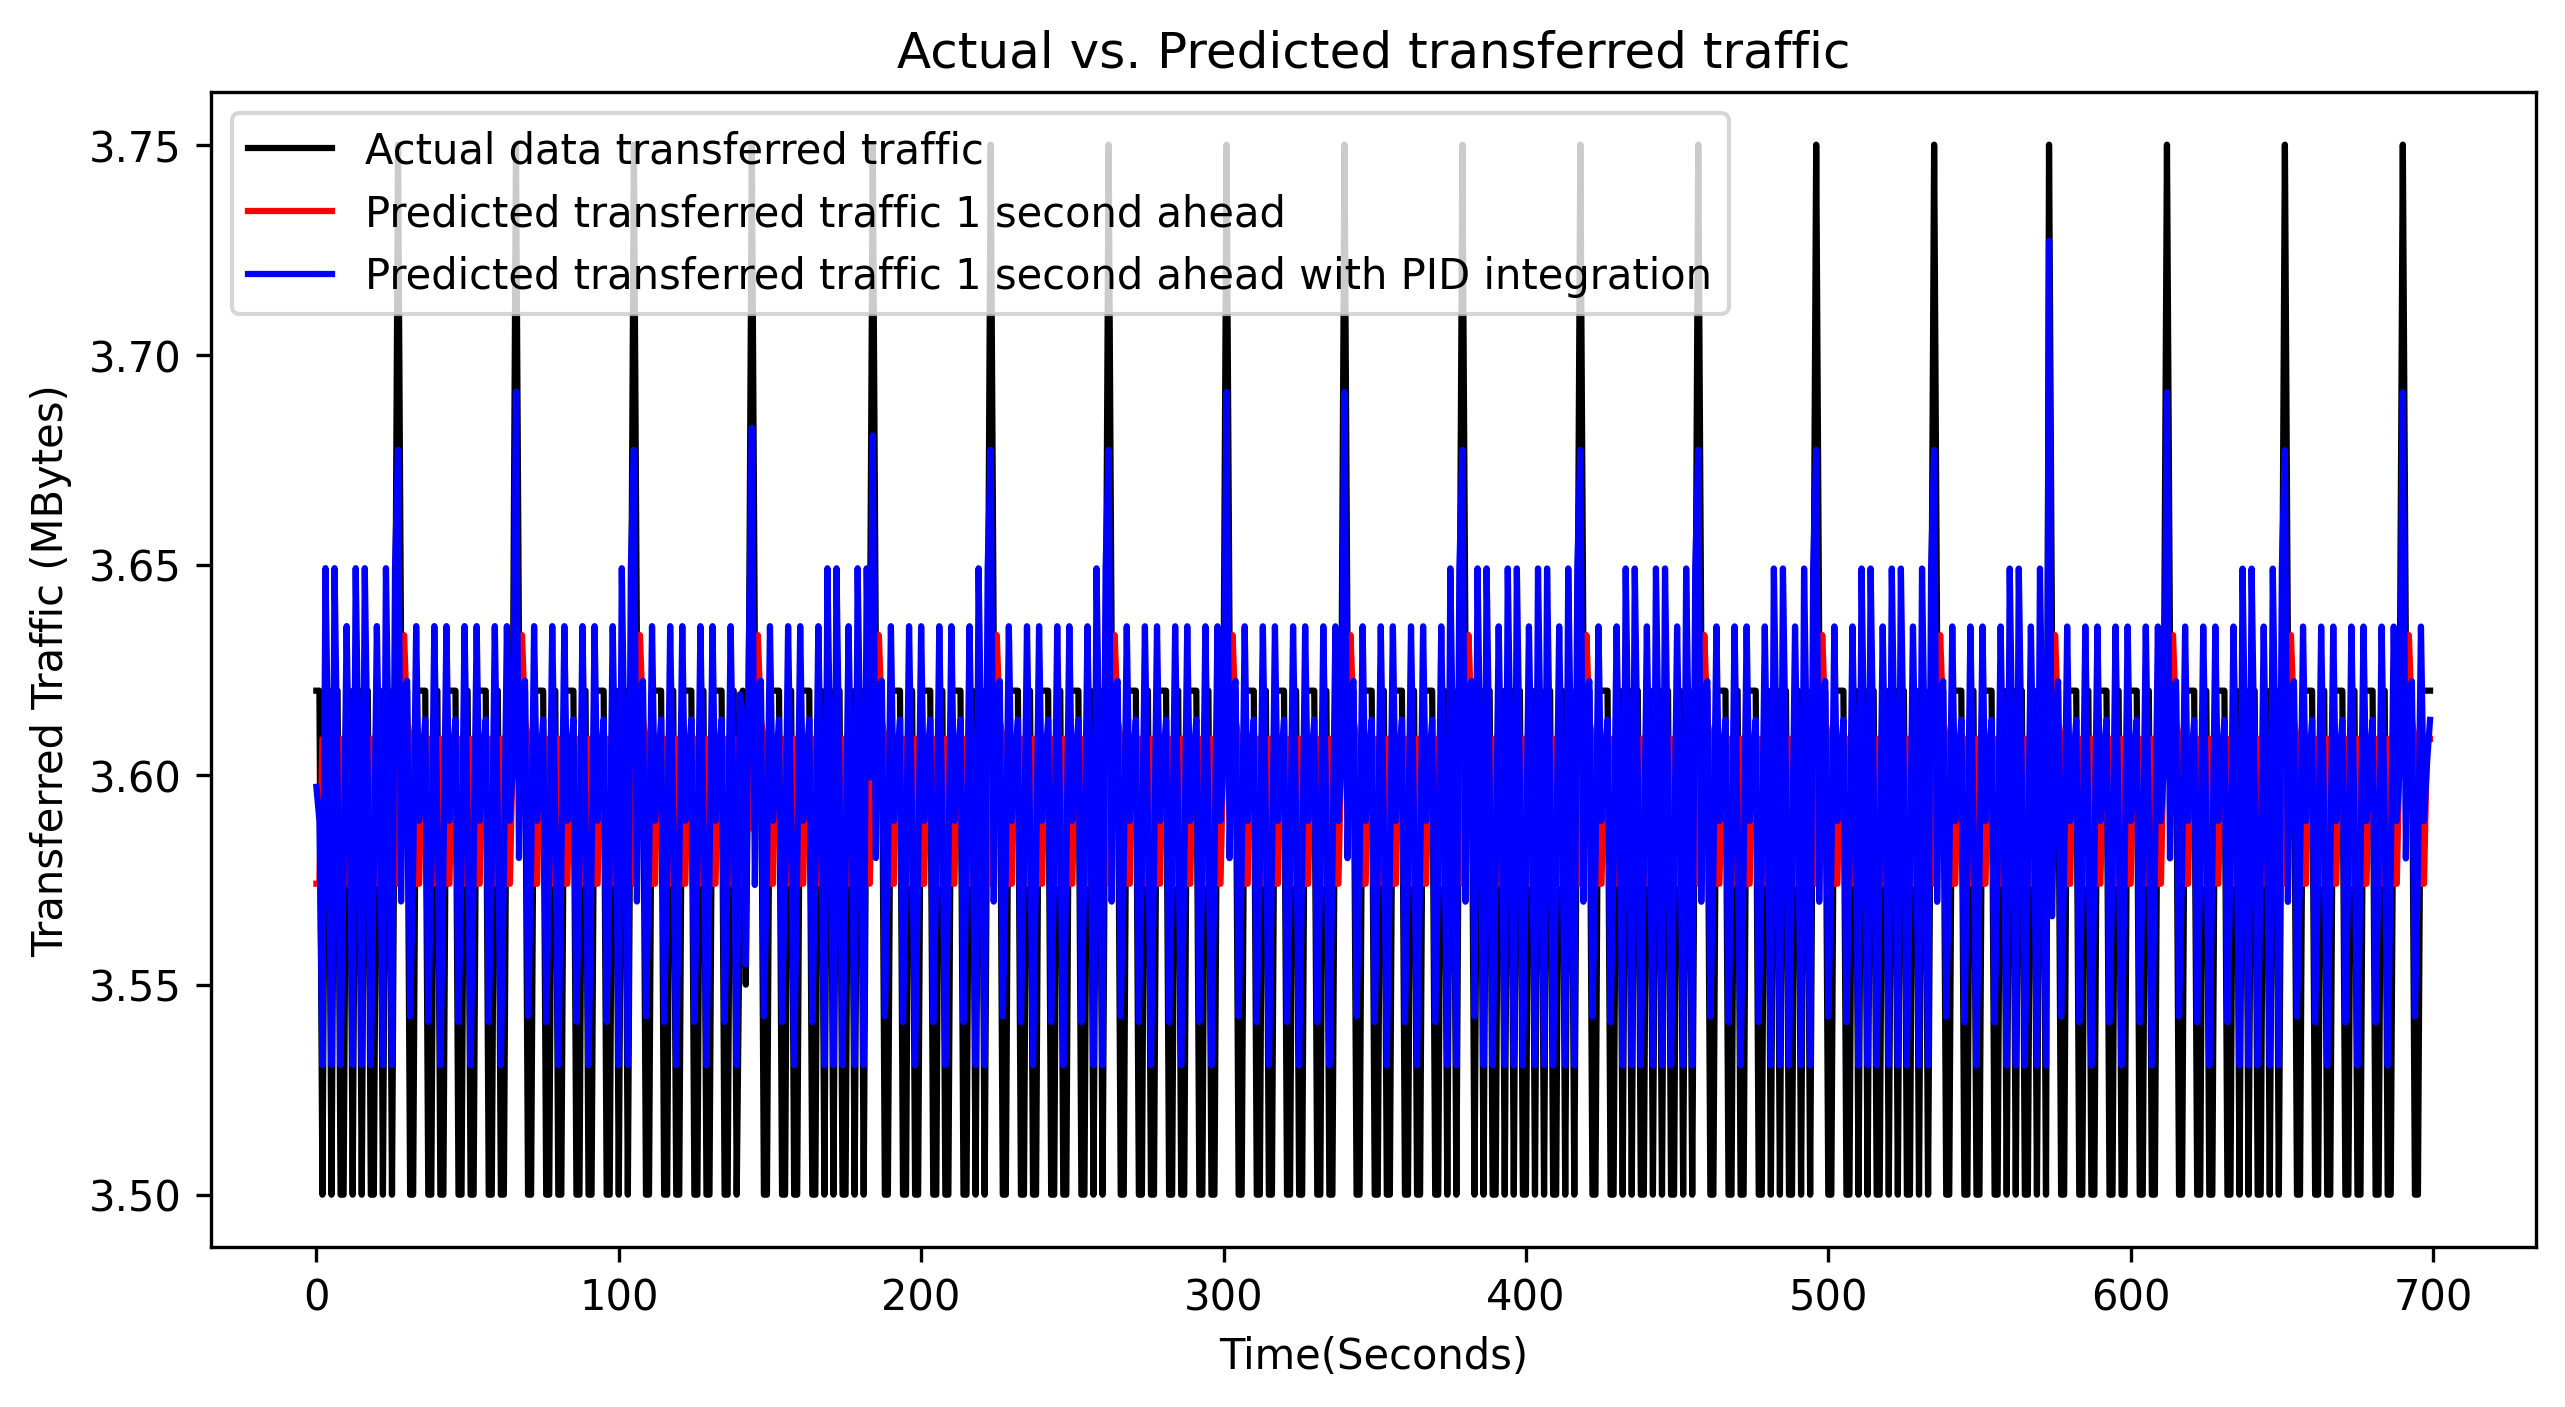

In [44]:
plt.figure(figsize=(10, 5), dpi=300)
plt.plot(r_test_w[:700], 'k-', label='Actual data transferred traffic')
plt.plot(y_test_LSTM[:700], 'r-', label='Predicted transferred traffic 1 second ahead')
plt.plot(y_test_LSTM_new[:700], 'b-', label='Predicted transferred traffic 1 second ahead with PID integration')
plt.ylabel('Transferred Traffic (MBytes)')
plt.xlabel('Time(Seconds)')
plt.title(' Actual vs. Predicted transferred traffic ')  # Adding a title for context
plt.legend()
plt.show()

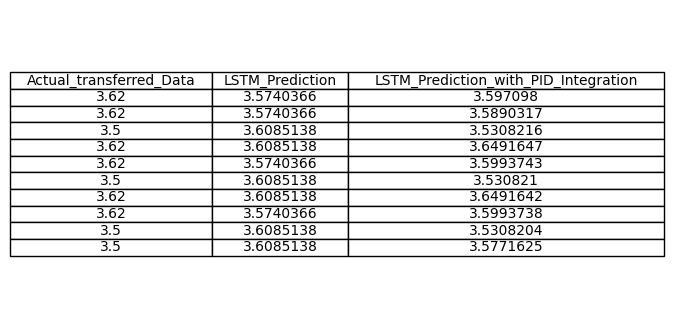

In [46]:
# Extracting values from index 0 to 10
r_test_dense_selected = np.array(r_test_w[0:10])
y_test_LSTM_selected = np.array(y_test_LSTM[0:10])
y_test_LSTM_new_selected = np.array(y_test_LSTM_new[0:10])

# Flattenning the arrays
r_test_dense_1d = r_test_dense_selected.flatten()
y_test_LSTM_1d = y_test_LSTM_selected.flatten()
y_test_LSTM_new_1d = y_test_LSTM_new_selected.flatten()

# Creating DataFrame
data_pred = {
    'Actual_transferred_Data': r_test_dense_1d,
    'LSTM_Prediction': y_test_LSTM_1d,
    'LSTM_Prediction_with_PID_Integration': y_test_LSTM_new_1d
}
df_pred = pd.DataFrame(data_pred)

# Creating figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

ax.axis('tight')
ax.axis('off')

# Creating table
table = ax.table(cellText=df_pred.values,
                 colLabels=df_pred.columns,
                 cellLoc='center',
                 loc='center')

# Setting font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjusting cell heights
table.auto_set_column_width(col=list(range(len(df_pred.columns))))
table.auto_set_column_width(-1)

# Showing table
plt.show()


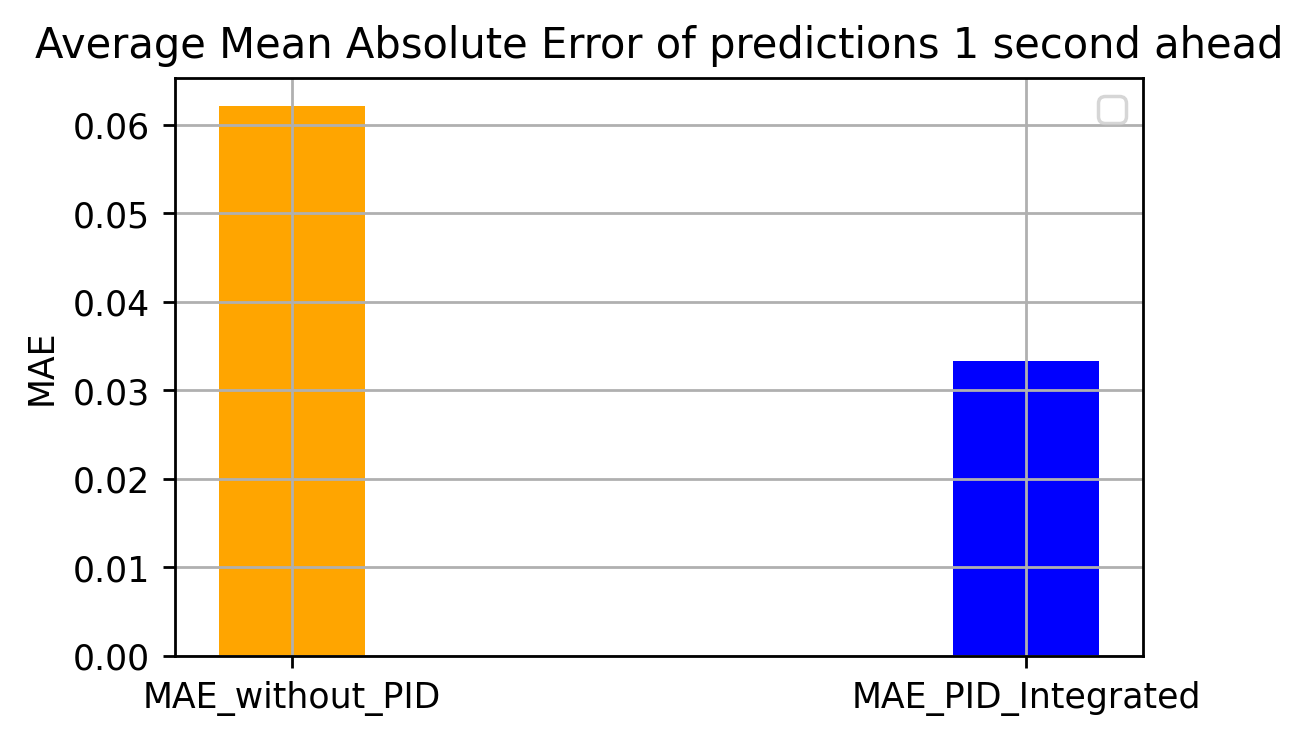

In [52]:
values = {'MAE_without_PID': mae_test_LSTM, 'MAE_PID_Integrated': mae_test_LSTM_new}
colors = ['orange', 'blue']
bar_width = 0.2

# Creating a figure with higher resolution
plt.figure(figsize=(5, 3), dpi=250)

# Plotting
plt.bar(values.keys(), values.values(), color=colors, width=bar_width)
x_pos = list(range(len(values)))

# Adding labels and title
plt.ylabel('MAE')
plt.title('Average Mean Absolute Error of predictions 1 second ahead')
plt.xticks(x_pos, values.keys())
plt.legend()
plt.grid(True)
plt.show()